In [1]:
import os
import math
import datetime
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

## Setup

In [2]:
driver_ids = []
with open('driver_ids.csv', 'r') as f:
    driver_ids_raw = f.readlines()[1:]
    for row in driver_ids_raw:
        parsed_row = row[:-1].split(',')
        parsed_row[1] = datetime.datetime.strptime(parsed_row[1], '%Y-%m-%d %H:%M:%S')
        driver_ids.append(parsed_row)
    
print("Number of drivers:", len(driver_ids))

driver_ids_map = {}
for driver_id, onboard_date in driver_ids:
    driver_ids_map[driver_id] = onboard_date

('Number of drivers:', 937)


In [3]:
ride_ids = []
with open('ride_ids.csv', 'r') as f:
    ride_ids_raw = f.readlines()[1:]
    for row in ride_ids_raw:
        parsed_row = row[:-1].split(',')
        for i in range(2,5):
            parsed_row[i] = int(parsed_row[i]) 
        ride_ids.append(parsed_row)

print("Number of rides:", len(ride_ids))

ride_ids_map = {}
for driver_id, ride_id, ride_distance, ride_duration, ride_prime_time in ride_ids:
    ride_ids_map[ride_id] = [ride_distance, ride_duration, ride_prime_time]
    
driver_to_ride = {}
ride_to_driver = {}
for driver_id, ride_id, ride_distance, ride_duration, ride_prime_time in ride_ids:
    driver_to_ride.setdefault(driver_id, []).append(ride_id)
    ride_to_driver[driver_id] = ride_id

('Number of rides:', 193502)


In [4]:
ride_timestamps = []
with open('ride_timestamps.csv', 'r') as f:
    ride_timestamps_raw = f.readlines()[1:]
    for row in ride_timestamps_raw:
        parsed_row = row[:-1].split(',')
        try:
            parsed_row[2] = datetime.datetime.strptime(parsed_row[2], '%Y-%m-%d %H:%M:%S')
        except:
            print(row)
            # TODO: 72f0fa0bd86800e9da5c4dced32c8735 has a missing timestamp with arrived at.
            # It is currently hard coded in using the picked up at time. This needs to be checked.
            parsed_row[2] = datetime.datetime.strptime("2016-04-20 12:02:20", '%Y-%m-%d %H:%M:%S')
        ride_timestamps.append(parsed_row)
    
print("Number of rides:", len(ride_timestamps))

ride_timestamps_map = {}
for ride_id, event, timestamp in ride_timestamps:
    #ride_timestamps_map[ride_id] = [event, timestamp]
    ride_timestamps_map.setdefault(ride_id, {})[event] = timestamp

72f0fa0bd86800e9da5c4dced32c8735,arrived_at,

('Number of rides:', 970405)


In [5]:
data_structures = '''
List of Data Structures

driver_ids: 937 rows of ['driver_id', driver_onboard_date (datetime)]
driver_ids_map: 'driver_id' -> driver_onboard_date (datetime)

ride_ids: 193502 rows of ['driver_id', 'ride_id', ride_distance (int, m), ride_duration (int, s), ride_prime_time (int)]
ride_ids_map: 'ride_id' -> [ride_distance (int, m), ride_duration (int, s), ride_prime_time]
driver_to_ride: 'driver_id' -> list of ride_ids
ride_to_driver: 'ride_id' -> 'driver_id'

ride_timestamps: 970405 rows of ['ride_id', 'event', timestamp (datetime)]
ride_timestamps_map: 'ride_id' -> ('event' -> timestamp (datetime))

list of prime times: [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 500]
list of events: ['requested_at', 'dropped_off_at', 'accepted_at', 'picked_up_at', 'arrived_at']
'''
print(data_structures)


List of Data Structures

driver_ids: 937 rows of ['driver_id', driver_onboard_date (datetime)]
driver_ids_map: 'driver_id' -> driver_onboard_date (datetime)

ride_ids: 193502 rows of ['driver_id', 'ride_id', ride_distance (int, m), ride_duration (int, s), ride_prime_time (int)]
ride_ids_map: 'ride_id' -> [ride_distance (int, m), ride_duration (int, s), ride_prime_time]
driver_to_ride: 'driver_id' -> list of ride_ids
ride_to_driver: 'ride_id' -> 'driver_id'

ride_timestamps: 970405 rows of ['ride_id', 'event', timestamp (datetime)]
ride_timestamps_map: 'ride_id' -> ('event' -> timestamp (datetime))

list of prime times: [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 500]
list of events: ['requested_at', 'dropped_off_at', 'accepted_at', 'picked_up_at', 'arrived_at']



## Average Projected Driver Lifetime

Number of days


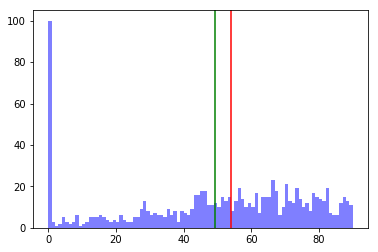

('Lifetime Days Mean:', 49.200640341515474, 'Lifetime Days Median:', 54.0)


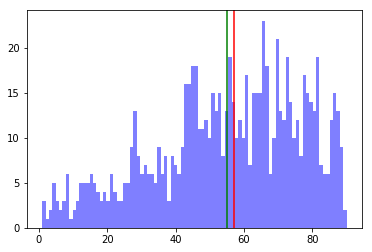

('Lifetime Days Mean Clean:', 55.07885304659498, 'Lifetime Days Median Clean:', 57.0)


In [6]:
print("Number of days")

driver_days = {}
for driver_id, onboard_date in driver_ids:
    max_time = 0
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            max_time = max(max_time, (ride_timestamps_map[ride_id]['arrived_at'] - onboard_date).days)
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    driver_days[driver_id] = max_time

lifetime_days = list(driver_days.values())
lifetime_days_mean = np.mean(np.asarray(lifetime_days))
lifetime_days_median = np.median(np.asarray(lifetime_days))

num_bins = 90
n, bins, patches = plt.hist(lifetime_days, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_days_mean, color='green')
plt.axvline(x=lifetime_days_median, color='red')
plt.show()
print("Lifetime Days Mean:", lifetime_days_mean, "Lifetime Days Median:", lifetime_days_median)

lifetime_days_clean = [x for x in lifetime_days if x != 0]
lifetime_days_mean_clean = np.mean(np.asarray(lifetime_days_clean))
lifetime_days_median_clean = np.median(np.asarray(lifetime_days_clean))
n, bins, patches = plt.hist(lifetime_days_clean, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_days_mean_clean, color='green')
plt.axvline(x=lifetime_days_median_clean, color='red')
plt.show()
print("Lifetime Days Mean Clean:", lifetime_days_mean_clean, "Lifetime Days Median Clean:", lifetime_days_median_clean)

Number of rides


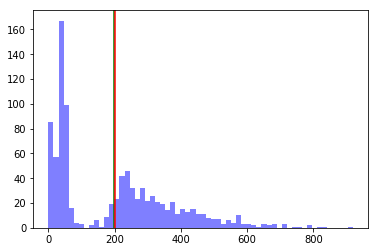

('Lifetime Rides Mean:', 198.3895410885806, 'Lifetime Rides Median:', 200.0)


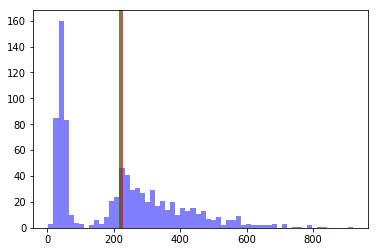

('Lifetime Rides Clean Mean:', 217.67096018735364, 'Lifetime Rides Clean Median:', 223.0)
83


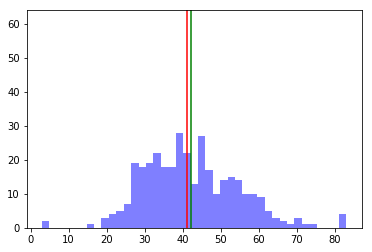

('Lifetime Rides Short Mean:', 42.176811594202896, 'Lifetime Rides Short Median:', 41.0)


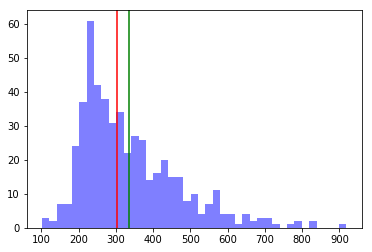

('Lifetime Rides Long Mean:', 336.6208251473477, 'Lifetime Rides Long Median:', 302.0)


In [7]:
print("Number of rides")
lifetime_rides = []
for driver_id, onboard_date in driver_ids:
    lifetime_rides.append(len(driver_to_ride.get(driver_id,[])))
lifetime_rides_mean = np.mean(np.asarray(lifetime_rides))
lifetime_rides_median = np.median(np.asarray(lifetime_rides))

num_bins = 60
n, bins, patches = plt.hist(lifetime_rides, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_rides_mean, color='green')
plt.axvline(x=lifetime_rides_median, color='red')
plt.show()
print("Lifetime Rides Mean:", lifetime_rides_mean, "Lifetime Rides Median:", lifetime_rides_median)

lifetime_rides_clean = [x for x in lifetime_rides if x != 0]
lifetime_rides_clean_mean = np.mean(np.asarray(lifetime_rides_clean))
lifetime_rides_clean_median = np.median(np.asarray(lifetime_rides_clean))
n, bins, patches = plt.hist(lifetime_rides_clean, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_rides_clean_mean, color='green')
plt.axvline(x=lifetime_rides_clean_median, color='red')
plt.show()
print("Lifetime Rides Clean Mean:", lifetime_rides_clean_mean, "Lifetime Rides Clean Median:", lifetime_rides_clean_median)

num_bins = 41
lifetime_rides_short = [x for x in lifetime_rides_clean if x < 100]
print(max(lifetime_rides_short))
lifetime_rides_short_mean = np.mean(np.asarray(lifetime_rides_short))
lifetime_rides_short_median = np.median(np.asarray(lifetime_rides_short))
n, bins, patches = plt.hist(lifetime_rides_short, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_rides_short_mean, color='green')
plt.axvline(x=lifetime_rides_short_median, color='red')
plt.ylim(top=64.05)
plt.show()
print("Lifetime Rides Short Mean:", lifetime_rides_short_mean, "Lifetime Rides Short Median:", lifetime_rides_short_median)

lifetime_rides_long = [x for x in lifetime_rides_clean if x >= 100]
lifetime_rides_long_mean = np.mean(np.asarray(lifetime_rides_long))
lifetime_rides_long_median = np.median(np.asarray(lifetime_rides_long))
n, bins, patches = plt.hist(lifetime_rides_long, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_rides_long_mean, color='green')
plt.axvline(x=lifetime_rides_long_median, color='red')
plt.show()
print("Lifetime Rides Long Mean:", lifetime_rides_long_mean, "Lifetime Rides Long Median:", lifetime_rides_long_median)

Number of hours


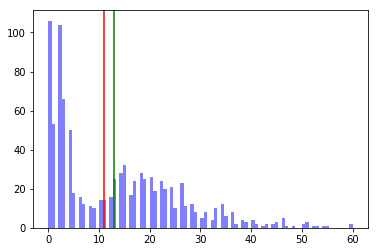

('Lifetime Hours Mean:', 13.00213447171825, 'Lifetime Hours Median:', 11.0)


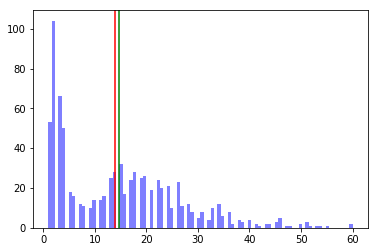

('Lifetime Hours Mean Clean:', 14.660649819494585, 'Lifetime Hours Median Clean:', 14.0)
6


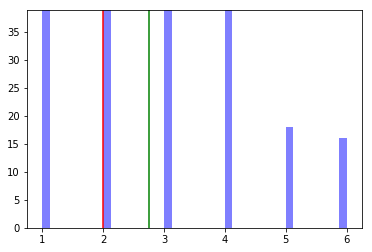

('Lifetime Rides Short Mean:', 2.752442996742671, 'Lifetime Rides Short Median:', 2.0)


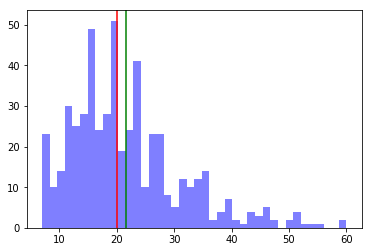

('Lifetime Rides Long Mean:', 21.637404580152673, 'Lifetime Rides Long Median:', 20.0)


In [8]:
print("Number of hours")

driver_hours = {}
for driver_id, onboard_date in driver_ids:
    num_seconds = 0
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            num_seconds += (ride_timestamps_map[ride_id]['arrived_at'] - ride_timestamps_map[ride_id]['accepted_at']).seconds
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    driver_hours[driver_id] = num_seconds / 60 / 60

lifetime_hours = list(driver_hours.values())
lifetime_hours_mean = np.mean(np.asarray(lifetime_hours))
lifetime_hours_median = np.median(np.asarray(lifetime_hours))

num_bins = 90
n, bins, patches = plt.hist(lifetime_hours, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_hours_mean, color='green')
plt.axvline(x=lifetime_hours_median, color='red')
plt.show()
print("Lifetime Hours Mean:", lifetime_hours_mean, "Lifetime Hours Median:", lifetime_hours_median)

lifetime_hours_clean = [x for x in lifetime_hours if x != 0]
lifetime_hours_mean_clean = np.mean(np.asarray(lifetime_hours_clean))
lifetime_hours_median_clean = np.median(np.asarray(lifetime_hours_clean))
n, bins, patches = plt.hist(lifetime_hours_clean, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_hours_mean_clean, color='green')
plt.axvline(x=lifetime_hours_median_clean, color='red')
plt.show()
print("Lifetime Hours Mean Clean:", lifetime_hours_mean_clean, "Lifetime Hours Median Clean:", lifetime_hours_median_clean)

num_bins = 40
lifetime_hours_short = [x for x in lifetime_hours_clean if x < 7]
print(max(lifetime_hours_short))
lifetime_hours_short_mean = np.mean(np.asarray(lifetime_hours_short))
lifetime_hours_short_median = np.median(np.asarray(lifetime_hours_short))
n, bins, patches = plt.hist(lifetime_hours_short, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_hours_short_mean, color='green')
plt.axvline(x=lifetime_hours_short_median, color='red')
plt.ylim(top=38.85)
plt.show()
print("Lifetime Rides Short Mean:", lifetime_hours_short_mean, "Lifetime Rides Short Median:", lifetime_hours_short_median)

lifetime_hours_long = [x for x in lifetime_hours_clean if x >= 7]
lifetime_hours_long_mean = np.mean(np.asarray(lifetime_hours_long))
lifetime_hours_long_median = np.median(np.asarray(lifetime_hours_long))
n, bins, patches = plt.hist(lifetime_hours_long, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_hours_long_mean, color='green')
plt.axvline(x=lifetime_hours_long_median, color='red')
plt.show()
print("Lifetime Rides Long Mean:", lifetime_hours_long_mean, "Lifetime Rides Long Median:", lifetime_hours_long_median)

Scatter plot of days vs. rides


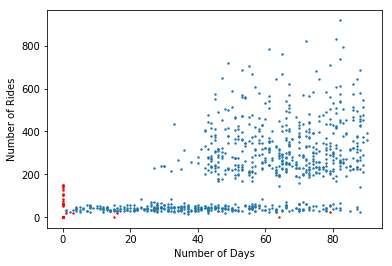

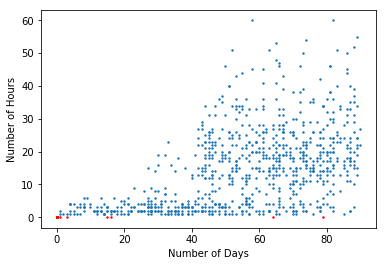

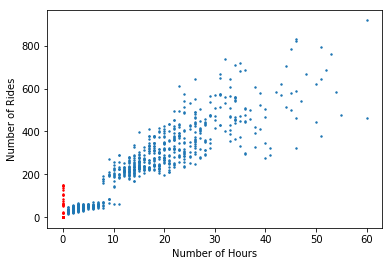

In [9]:
print("Scatter plot of days vs. rides")
x_days_clean = []
y_rides_clean = []
x_days_full = []
y_rides_full = []
for driver_id, days in driver_days.items():
    if driver_hours[driver_id] != 0:
        x_days_clean.append(days)
        y_rides_clean.append(len(driver_to_ride.get(driver_id,[])))
    else:
        x_days_full.append(days)
        y_rides_full.append(len(driver_to_ride.get(driver_id,[])))
        
plt.xlabel('Number of Days')
plt.ylabel('Number of Rides')
plt.scatter(x_days_clean,y_rides_clean,s=2)
plt.scatter(x_days_full,y_rides_full,s=2,color='red')
plt.show()

x_days_clean = []
y_hours_clean = []
x_days_full = []
y_hours_full = []
for driver_id, days in driver_days.items():
    if driver_hours[driver_id] != 0:
        x_days_clean.append(days)
        y_hours_clean.append(driver_hours[driver_id])
    else:
        x_days_full.append(days)
        y_hours_full.append(driver_hours[driver_id])
        
plt.xlabel('Number of Days')
plt.ylabel('Number of Hours')
plt.scatter(x_days_clean,y_hours_clean,s=2)
plt.scatter(x_days_full,y_hours_full,s=2,color='red')
plt.show()

x_hours_clean = []
y_rides_clean = []
x_hours_full = []
y_rides_full = []
for driver_id, hours in driver_hours.items():
    if driver_hours[driver_id] != 0:
        x_hours_clean.append(hours)
        y_rides_clean.append(len(driver_to_ride.get(driver_id,[])))
    else:
        x_hours_full.append(hours)
        y_rides_full.append(len(driver_to_ride.get(driver_id,[])))

plt.xlabel('Number of Hours')
plt.ylabel('Number of Rides')
plt.scatter(x_hours_clean,y_rides_clean,s=2)
plt.scatter(x_hours_full,y_rides_full,s=2,color='red')
plt.show()

In [10]:
driver_hours = {}
for driver_id, onboard_date in driver_ids:
    num_seconds = 0
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            num_seconds += (ride_timestamps_map[ride_id]['arrived_at'] - ride_timestamps_map[ride_id]['accepted_at']).seconds
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    driver_hours[driver_id] = num_seconds / 60 / 60

Heatmap plot of days vs. rides


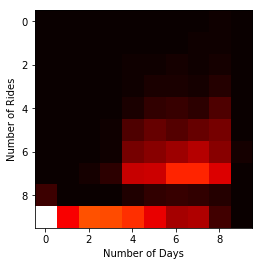

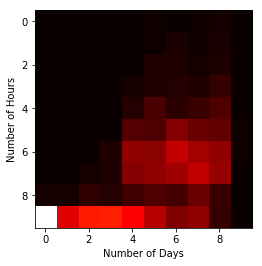

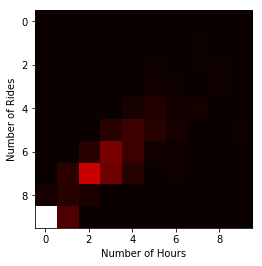

In [11]:
print("Heatmap plot of days vs. rides")
days_rides_heatmap = np.zeros((10,10))
for driver_id, days in driver_days.items():
    x_days = days
    y_rides = len(driver_to_ride.get(driver_id,[]))
    days_rides_heatmap[max(0,9-int(y_rides/100)),min(9,int(x_days/10))] += 1

plt.xlabel('Number of Days')
plt.ylabel('Number of Rides')
plt.imshow(days_rides_heatmap, cmap='hot')
plt.show()

days_hours_heatmap = np.zeros((10,10))
for driver_id, days in driver_days.items():
    x_days = days
    y_hours = driver_hours[driver_id]
    days_hours_heatmap[max(0,9-int(y_hours/6)),min(9,int(x_days/10))] += 1
    
plt.xlabel('Number of Days')
plt.ylabel('Number of Hours')
plt.imshow(days_hours_heatmap, cmap='hot')
plt.show()

hours_rides_heatmap = np.zeros((10,10))
for driver_id, hours in driver_hours.items():
    x_hours = hours
    y_rides = len(driver_to_ride.get(driver_id,[]))
    hours_rides_heatmap[max(0,9-int(y_rides/100)),min(9,int(x_hours/6))] += 1
    
plt.xlabel('Number of Hours')
plt.ylabel('Number of Rides')
plt.imshow(hours_rides_heatmap, cmap='hot')
plt.show()

## Categories of Drivers

Day of week


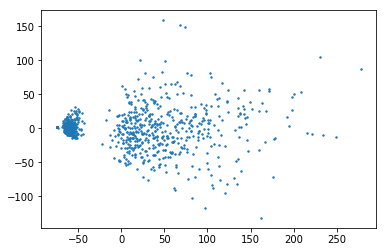

('Component 1 (count):', array([0.28132626, 0.32709573, 0.36623304, 0.3997014 , 0.44944649,
       0.45488873, 0.33324191]))
('Component 2 (weekend):', array([-0.21418311, -0.33965469, -0.31149743, -0.28765337, -0.10146957,
        0.54830229,  0.58996076]))
('Component 3 (??):', array([ 0.51230235,  0.28849935,  0.04305716, -0.12423998, -0.52027016,
       -0.31455726,  0.51710505]))
('Explained Variance:', array([4826.64440583,  764.43579472,  246.77917925,  162.57920483,
        137.18888002,  115.85724781,  108.42134342]))


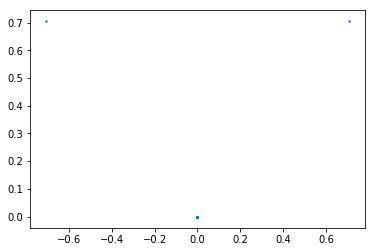

('Component 1 (weekend):', array([ 0.00000000e+00, -1.46862710e-16,  7.07106781e-01,  0.00000000e+00,
       -7.07106781e-01,  0.00000000e+00,  0.00000000e+00]))
('Component 2 (friday night?):', array([0.        , 0.        , 0.70710678, 0.        , 0.70710678,
       0.        , 0.        ]))
('Component 3 (??):', array([ 0.00000000e+00, -1.00000000e+00, -1.11022302e-16,  0.00000000e+00,
        1.11022302e-16,  0.00000000e+00,  0.00000000e+00]))
('Explained Variance:', array([1.19617225e-03, 1.19331401e-03, 2.50230338e-36, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]))


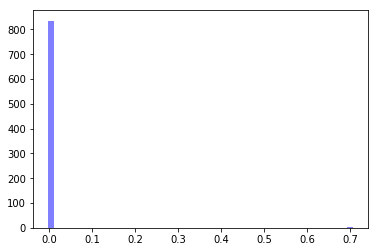

/Users/kavyakopparapu/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


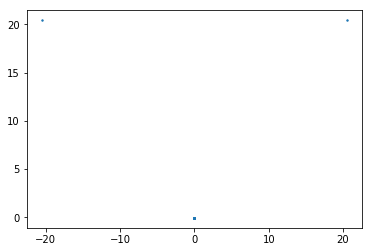

('Component 1 (weekend):', array([ 0.00000000e+00, -1.46862710e-16,  7.07106781e-01,  0.00000000e+00,
       -7.07106781e-01,  0.00000000e+00,  0.00000000e+00]))
('Component 2 (friday night?):', array([0.        , 0.        , 0.70710678, 0.        , 0.70710678,
       0.        , 0.        ]))
('Component 3 (??):', array([ 0.00000000e+00, -1.00000000e+00, -1.11022302e-16,  0.00000000e+00,
        1.11022302e-16,  0.00000000e+00,  0.00000000e+00]))
('Explained Variance:', array([1.19617225e-03, 1.19331401e-03, 2.50230338e-36, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]))


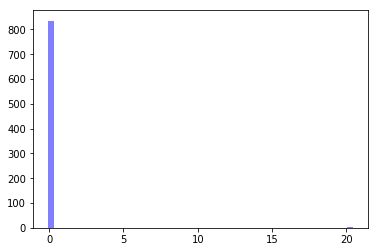

In [12]:
print("Day of week")

# Full
driver_weekday = {} # Note: [0] is Monday
for driver_id, onboard_date in driver_ids:
    weekday_counts = [0 for x in range(7)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            weekday_counts[ride_timestamps_map[ride_id]['arrived_at'].weekday()] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    driver_weekday[driver_id] = weekday_counts
    
X = np.asarray([days for driver_id, days in driver_weekday.items()])
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:,0],X_pca[:,1],s=2)
plt.show()

print("Component 1 (count):", pca.components_[0])
print("Component 2 (weekend):", pca.components_[1])
print("Component 3 (??):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

# Clean
driver_weekday_clean = {} # Note: [0] is Monday
for driver_id, onboard_date in driver_ids:
    weekday_counts = [0 for x in range(7)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            weekday_counts[ride_timestamps_map[ride_id]['arrived_at'].weekday()] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if sum(weekday_counts) > 0:
        total = sum(weekday_counts)
        for i in range(7):
            weekday_counts[i] = weekday_counts[i] / total
        driver_weekday_clean[driver_id] = weekday_counts

X_clean = np.asarray([days for driver_id, days in driver_weekday_clean.items()])
pca = PCA(n_components=7)
X_pca_clean = pca.fit_transform(X_clean)
plt.scatter(X_pca_clean[:,0],X_pca_clean[:,1],s=2)
plt.show()

print("Component 1 (weekend):", pca.components_[0])
print("Component 2 (friday night?):", pca.components_[1])
print("Component 3 (??):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

num_bins = 50
n, bins, patches = plt.hist(X_pca_clean[:,1], num_bins, facecolor='blue', alpha=0.5)
plt.show()

# Normed
driver_weekday_norm = driver_weekday_clean
X_norm = np.asarray([days for driver_id, days in driver_weekday_norm.items()])
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=7))])
X_pca_norm = pipeline.fit_transform(X_norm)
plt.scatter(X_pca_norm[:,0],X_pca_norm[:,1],s=2)
plt.show()

print("Component 1 (weekend):", pca.components_[0])
print("Component 2 (friday night?):", pca.components_[1])
print("Component 3 (??):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

num_bins = 50
n, bins, patches = plt.hist(X_pca_norm[:,1], num_bins, facecolor='blue', alpha=0.5)
plt.show()

Percentage of weekend rides
('Only week days percentage:', 0)
('Only weekend percentage:', 0)


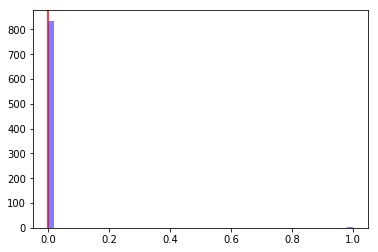

In [13]:
print("Percentage of weekend rides")

driver_weekday_clean = {} # Note: [0] is Monday
for driver_id, onboard_date in driver_ids:
    weekday_counts = [0 for x in range(7)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            weekday_counts[ride_timestamps_map[ride_id]['arrived_at'].weekday()] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if sum(weekday_counts) > 0:
        total = sum(weekday_counts)
        driver_weekday_clean[driver_id] = (weekday_counts[5]+weekday_counts[6])/total
        
print("Only week days percentage:",len([x for x in driver_weekday_clean.values() if x < .001])/len(driver_weekday_clean.values())*100)
print("Only weekend percentage:",len([x for x in driver_weekday_clean.values() if x > .99])/len(driver_weekday_clean.values())*100)


weekend_percentages = np.asarray(list(driver_weekday_clean.values()))
num_bins = 50
n, bins, patches = plt.hist(weekend_percentages, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=2/7, color='red')
plt.show()

In [14]:
print("Entropy of week")

driver_weekday_clean = {} # Note: [0] is Monday
for driver_id, onboard_date in driver_ids:
    weekday_counts = [0 for x in range(7)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            weekday_counts[ride_timestamps_map[ride_id]['arrived_at'].weekday()] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if sum(weekday_counts) > 0:
        entropy = 0
        total = sum(weekday_counts)
        for i in range(7):
            if weekday_counts[i] > 0:
                entropy -= weekday_counts[i]/total * math.log(weekday_counts[i]/total)
        driver_weekday_clean[driver_id] = entropy
                
weekend_percentages = np.asarray(list(driver_weekday_clean.values()))
num_bins = 50
n, bins, patches = plt.hist(weekend_percentages, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=math.log(7), color='red')
plt.show()

print("Entropy of week vs. weekend")

driver_weekday_clean = {} # Note: [0] is Monday
for driver_id, onboard_date in driver_ids:
    weekday_counts = [0 for x in range(7)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            weekday_counts[ride_timestamps_map[ride_id]['arrived_at'].weekday()] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if sum(weekday_counts) > 0:
        entropy = 0
        total = sum(weekday_counts)
        weekday = np.sum(np.asarray(weekday_counts)[:5])
        weekend = np.sum(np.asarray(weekday_counts)[5:])
        if weekday > 0:
            entropy -= weekday/total*math.log(weekday/total)
        if weekend > 0:
            entropy -= weekend/total*math.log(weekend/total)
        driver_weekday_clean[driver_id] = entropy 
        
print("Just weekend or just weekdays percentage:",len([x for x in driver_weekday_clean.values() if x < .001])/len(driver_weekday_clean.values())*100)
        
weekend_percentages = np.asarray(list(driver_weekday_clean.values()))
num_bins = 50
n, bins, patches = plt.hist(weekend_percentages, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=math.log(2), color='red')
plt.show()

Entropy of week


ValueError: math domain error

Hour of day


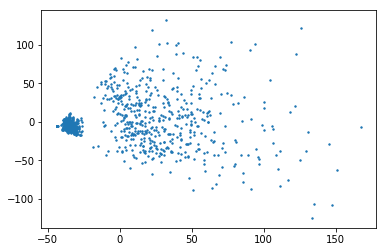

('Component 1 (count):', array([0.16886712, 0.12407257, 0.06558523, 0.02778441, 0.01929102,
       0.02520159, 0.05767338, 0.13572776, 0.17425706, 0.17917289,
       0.14792774, 0.14316655, 0.13250953, 0.13545515, 0.14663947,
       0.17698335, 0.21474736, 0.28069323, 0.355469  , 0.36126898,
       0.33157421, 0.31765501, 0.29961319, 0.22866422]))
('Component 2 (day):', array([-0.20834519, -0.17243879, -0.0980631 , -0.05124255, -0.02143862,
        0.0235173 ,  0.11509298,  0.24244031,  0.30572512,  0.35344589,
        0.31147649,  0.28161993,  0.25536862,  0.21839056,  0.17598449,
        0.14477269,  0.10981327,  0.06628768, -0.01412321, -0.10841353,
       -0.18862009, -0.26264331, -0.29000698, -0.2548589 ]))
('Component 3 (afternoon):', array([ 0.20785648,  0.19827742,  0.13899187,  0.09011566,  0.07939437,
        0.10084261,  0.18937949,  0.29526419,  0.31608927,  0.3065955 ,
        0.18027967,  0.09110444, -0.04239152, -0.14821941, -0.21369494,
       -0.28796631, -0.31666229, 

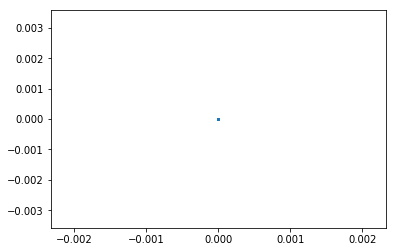

('Component 1 (day):', array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]))
('Component 2 (afternoon):', array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]))
('Component 3 (??):', array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]))
('Explained Variance:', array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]))


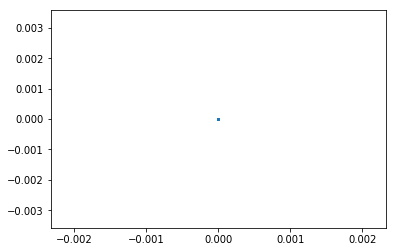

('Component 1 (day):', array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]))
('Component 2 (afternoon):', array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]))
('Component 3 (??):', array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]))
('Explained Variance:', array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]))


In [16]:
print("Hour of day")

# Full
driver_weekday = {}
for driver_id, onboard_date in driver_ids:
    hour_counts = [0 for x in range(24)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            hour_counts[int((ride_timestamps_map[ride_id]['accepted_at'].hour+ride_timestamps_map[ride_id]['arrived_at'].hour)/2)] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    driver_weekday[driver_id] = hour_counts

X = np.asarray([days for driver_id, days in driver_weekday.items()])
pca = PCA(n_components=24)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:,0],X_pca[:,1],s=2)
plt.show()

print("Component 1 (count):", pca.components_[0])
print("Component 2 (day):", pca.components_[1])
print("Component 3 (afternoon):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

# Clean
driver_weekday_clean = {}
for driver_id, onboard_date in driver_ids:
    hour_counts = [0 for x in range(24)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            hour_counts[int((ride_timestamps_map[ride_id]['accepted_at'].hour+ride_timestamps_map[ride_id]['arrived_at'].hour)/2)] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if sum(hour_counts) > 0:
        total = sum(hour_counts)
        for i in range(24):
            hour_counts[i] = hour_counts[i]/total
        driver_weekday_clean[driver_id] = hour_counts

X_clean = np.asarray([days for driver_id, days in driver_weekday_clean.items()])
pca = PCA(n_components=24)
X_pca_clean = pca.fit_transform(X_clean)
plt.scatter(X_pca_clean[:,0],X_pca_clean[:,1],s=2)
plt.show()

print("Component 1 (day):", pca.components_[0])
print("Component 2 (afternoon):", pca.components_[1])
print("Component 3 (??):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

# Normed
X_norm = np.asarray([days for driver_id, days in driver_weekday_norm.items()])
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=24))])
X_pca_norm = pipeline.fit_transform(X_clean)
plt.scatter(X_pca_norm[:,0],X_pca_norm[:,1],s=2)
plt.show()

print("Component 1 (day):", pca.components_[0])
print("Component 2 (afternoon):", pca.components_[1])
print("Component 3 (??):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

Percentage of out of work day rides
('Just workday percentage:', 0)


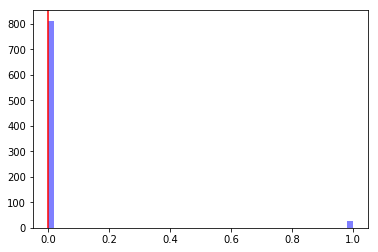

In [17]:
print("Percentage of out of work day rides")
        
driver_weekday_clean = {}
for driver_id, onboard_date in driver_ids:
    hour_counts = [0 for x in range(24)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            hour_counts[int((ride_timestamps_map[ride_id]['accepted_at'].hour+ride_timestamps_map[ride_id]['arrived_at'].hour)/2)] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if sum(hour_counts) > 0:
        total = sum(hour_counts)
        driver_weekday_clean[driver_id] = np.sum(np.asarray(hour_counts)[6:18]) / total
        
print("Just workday percentage:",len([x for x in driver_weekday_clean.values() if x > .99])/len(driver_weekday_clean.values())*100)

weekend_percentages = np.asarray(list(driver_weekday_clean.values()))
num_bins = 50
n, bins, patches = plt.hist(weekend_percentages, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=12/24, color='red')
plt.show()

## Cost Analysis Setup

In [128]:
def ride_cost(ride_distance, ride_duration, ride_prime_time):
    cost = 2.0+1.15*(ride_distance/1609.34)+0.22*(ride_duration/60.0)+1.75
    cost = min(max(5.0, cost), 500)
    return cost*((ride_prime_time+100)/100.0)

## Lifetime Value Setup

In [57]:
#total money made, total days active, total days employed, total hours active
#of the form {driver_id -> [total money, total days active, total days employed, total hours active]}
driver_lifetime_metadata = {} 
#data for every day of the form {driver_id -> {day number -> hours, money, or active}}
driver_lifetime_hours = {}
driver_lifetime_money = {}
driver_lifetime_active = {}

for driver_id, onboard_date in driver_ids:
    total_money = 0.0
    total_days_active = set()
    total_days_employed = 0
    total_hours_active = 0
                
    hours_temp = {}
    money_temp = {}
    active_temp = {}
    for ride_id in driver_to_ride.get(driver_id,[]):    
        try:
            ride_distance = ride_ids_map[ride_id][0]
            ride_duration = ride_ids_map[ride_id][1]
            ride_prime_time = ride_ids_map[ride_id][2]

            ride_money = ride_cost(ride_ids_map[ride_id][0],ride_ids_map[ride_id][1],ride_ids_map[ride_id][2])
            ride_day = (ride_timestamps_map[ride_id]['arrived_at'] - onboard_date).days

            total_money += ride_money
            total_days_active.add(ride_day)
            total_days_employed = max(total_days_employed, ride_day)
            total_hours_active += ride_duration

            if(ride_day in hours_temp):
                hours_temp[ride_day] += ride_duration
                money_temp[ride_day] += ride_money
            else:
                hours_temp[ride_day] = ride_duration
                money_temp[ride_day] = ride_money
            active_temp[ride_day] = 1
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    hours_temp = {k: v /60/60 for k, v in hours_temp.items()}
    driver_lifetime_hours[driver_id] = hours_temp
    driver_lifetime_money[driver_id] = money_temp
    driver_lifetime_active[driver_id] = active_temp
    driver_lifetime_metadata[driver_id] = [total_money,len(total_days_active),total_days_employed+1,total_hours_active / 60 / 60]
#print(driver_lifetime_active)

Histogram of (#active/#employed)*100 days


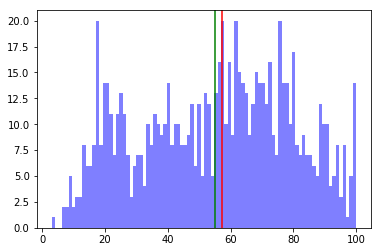

('Active/Employed Days Mean:', 55.07159105176969, 'Active/Employed Days Median:', 57.333333333333336)
()


In [58]:
print("Histogram of (#active/#employed)*100 days")
active_over_employed = []
for driver_id, onboard_date in driver_ids:
    if(driver_lifetime_metadata[driver_id][1] > 0):
        active_over_employed.append(100*(driver_lifetime_metadata[driver_id][1]+0.0)/driver_lifetime_metadata[driver_id][2])
active_over_employed_mean = np.mean(np.asarray(active_over_employed))
active_over_employed_median = np.median(np.asarray(active_over_employed))
num_bins = 90
n, bins, patches = plt.hist(active_over_employed, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=active_over_employed_mean, color='green')
plt.axvline(x=active_over_employed_median, color='red')
plt.show()
print("Active/Employed Days Mean:", active_over_employed_mean, "Active/Employed Days Median:", active_over_employed_median)

print()

## Prime Time Analysis

### Prime Time Demand by Day of Week and Aggregate

Prime Time Demand on Monday


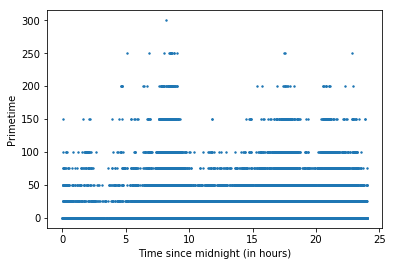

Prime Time Demand on Tuesday


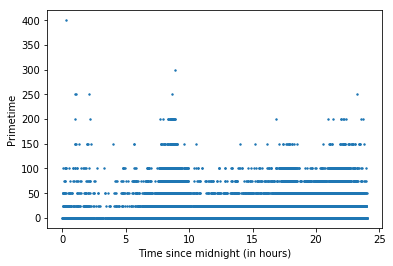

Prime Time Demand on Wednesday


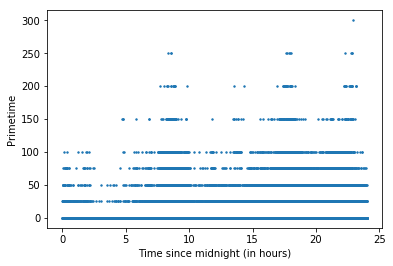

Prime Time Demand on Thursday


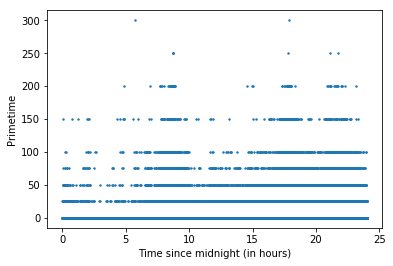

Prime Time Demand on Friday


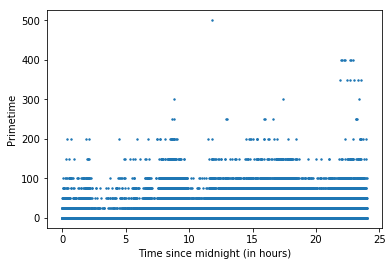

Prime Time Demand on Saturday


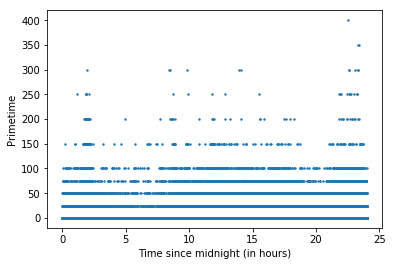

Prime Time Demand on Sunday


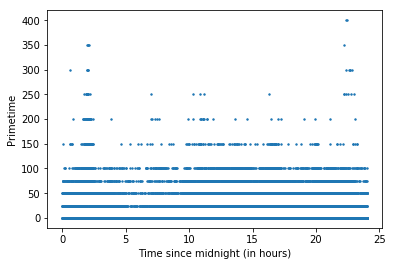

Aggregate Prime Time Demand


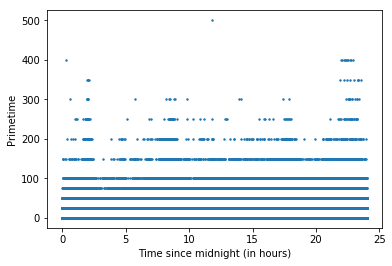

In [61]:
demand_times_by_day = [[0] for l in range(0,7)] #where monday is 0
primetime_by_day = [[0] for l in range(0,7)] #where monday is 0
demand_aggregate_times = [] 
primetime_aggregate = [] 
for driver_id, onboard_date in driver_ids:
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            ride_distance = ride_ids_map[ride_id][0]
            ride_duration = ride_ids_map[ride_id][1]
            ride_prime_time = ride_ids_map[ride_id][2]

            day = ride_timestamps_map[ride_id]['arrived_at'].weekday()
            now = ride_timestamps_map[ride_id]['requested_at']
            hrs_since_midnight = (now - now.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()/60.0/60.0

            demand_times_by_day[day].append(hrs_since_midnight)
            primetime_by_day[day].append(ride_prime_time)
            demand_aggregate_times.append(hrs_since_midnight)
            primetime_aggregate.append(ride_prime_time)
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
days_of_the_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for counter in range(0,7):
    print("Prime Time Demand on " + days_of_the_week[counter])
    plt.xlabel('Time since midnight (in hours)')
    plt.ylabel('Primetime')
    plt.scatter(demand_times_by_day[counter],primetime_by_day[counter],s=2)
    plt.show()

print("Aggregate Prime Time Demand")
plt.xlabel('Time since midnight (in hours)')
plt.ylabel('Primetime')
plt.scatter(demand_aggregate_times,primetime_aggregate,s=2)
plt.show()

### Prime Time Demand by Day of Week and Aggregate (Smooth and averaged)

Prime Time Demand on Monday
There were 7047 rides with primetime applied.


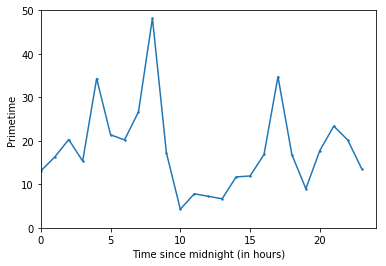

Prime Time Demand on Tuesday
There were 7114 rides with primetime applied.


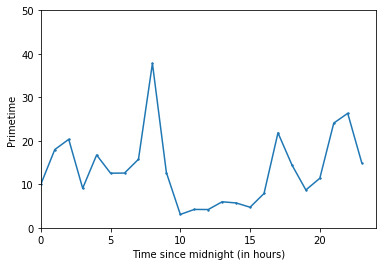

Prime Time Demand on Wednesday
There were 8235 rides with primetime applied.


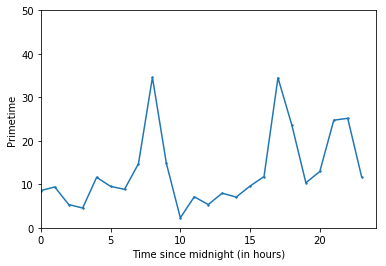

Prime Time Demand on Thursday
There were 9760 rides with primetime applied.


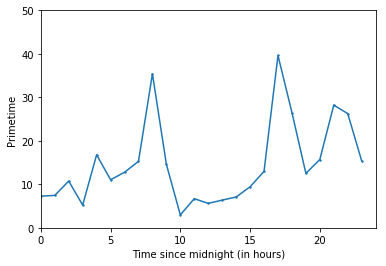

Prime Time Demand on Friday
There were 12067 rides with primetime applied.


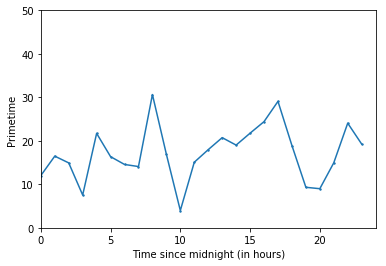

Prime Time Demand on Saturday
There were 10871 rides with primetime applied.


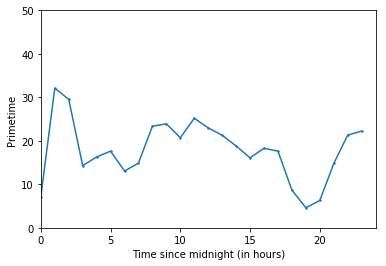

Prime Time Demand on Sunday
There were 10008 rides with primetime applied.


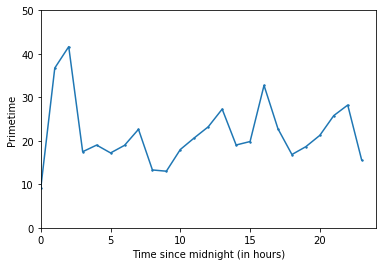

Aggregate Prime Time Demand


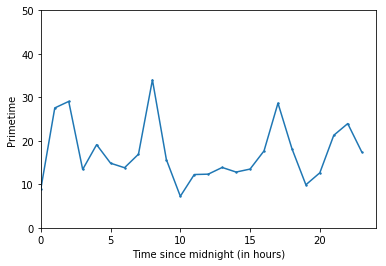

In [112]:
primetime_by_day_smooth = [{} for l in range(0,7)] #where monday is 0
primetime_aggregate_smooth = {}
number_points_per_time = [{} for l in range(0,7)]
number_primetime_by_day = [0 for l in range(0,7)]

for driver_id, onboard_date in driver_ids:
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            ride_distance = ride_ids_map[ride_id][0]
            ride_duration = ride_ids_map[ride_id][1]
            ride_prime_time = ride_ids_map[ride_id][2]

            day = ride_timestamps_map[ride_id]['arrived_at'].weekday()
            now = ride_timestamps_map[ride_id]['requested_at']
            hrs_since_midnight = (int)((now - now.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()/60.0/60.0)
            
            if(ride_prime_time > 0):
                number_primetime_by_day[day] += 1
            
            if(hrs_since_midnight in primetime_by_day_smooth[day]):
                primetime_by_day_smooth[day][hrs_since_midnight].append(ride_prime_time)
                primetime_aggregate_smooth[hrs_since_midnight].append(ride_prime_time)
                number_points_per_time[day][hrs_since_midnight] += 1
            elif(hrs_since_midnight in number_points_per_time):
                primetime_by_day_smooth[day][hrs_since_midnight] = [ride_prime_time]
                primetime_aggregate_smooth[hrs_since_midnight].append(ride_prime_time)
                number_points_per_time[day][hrs_since_midnight] = 1
            else:
                primetime_by_day_smooth[day][hrs_since_midnight] = [ride_prime_time]
                primetime_aggregate_smooth[hrs_since_midnight] = [ride_prime_time]
                number_points_per_time[day][hrs_since_midnight] = 1
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass

days_of_the_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for counter in range(0,7):
    print("Prime Time Demand on " + days_of_the_week[counter])
    print("There were " + str(number_primetime_by_day[counter]) + " rides with primetime applied.")
    plt.xlabel('Time since midnight (in hours)')
    plt.ylabel('Primetime')
    x = []
    y = []
    for time in number_points_per_time[counter].keys():
        x.append(time)
        y.append(sum(primetime_by_day_smooth[counter][time])/(0.0+ number_points_per_time[counter][time]))
    plt.scatter(x,y,s=2)
    plt.ylim([0, 50])
    plt.xlim([0, 24])
    plt.plot(x,y)
    plt.show()

print("Aggregate Prime Time Demand")
plt.xlabel('Time since midnight (in hours)')
plt.ylabel('Primetime')
x = []
y = []
for time in [k for k in range(0,24)]:
    x.append(time)
    y.append(sum(primetime_aggregate_smooth[time])/(sum([number_points_per_time[j][time] for j in range(0,7)])+0.0))
plt.scatter(x,y,s=2)
plt.ylim([0, 50])
plt.xlim([0, 24])
plt.plot(x,y)
plt.show()

### Prime Time Demand by Day of Week and Aggregate (Smooth and averaged) without 0s

Prime Time Demand on Monday


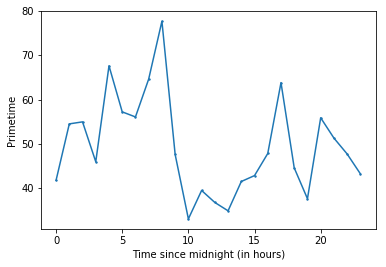

Prime Time Demand on Tuesday


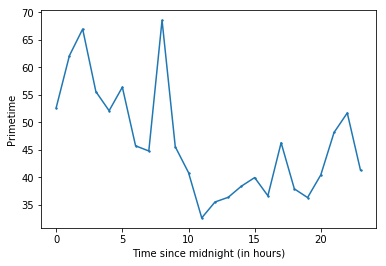

Prime Time Demand on Wednesday


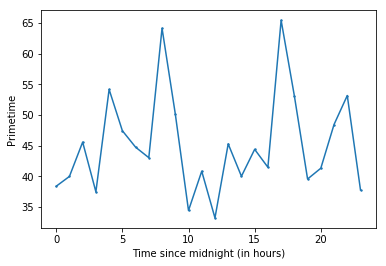

Prime Time Demand on Thursday


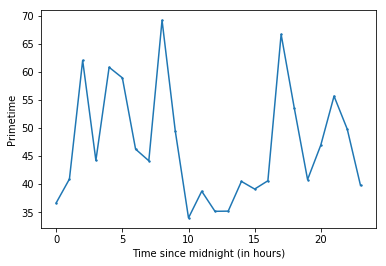

Prime Time Demand on Friday


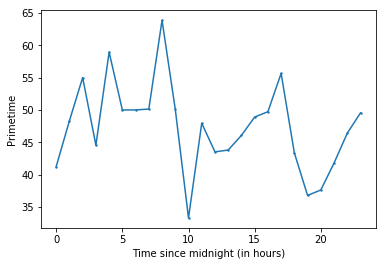

Prime Time Demand on Saturday


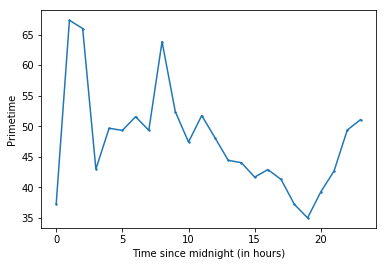

Prime Time Demand on Sunday


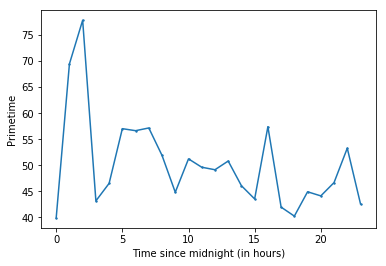

Aggregate Prime Time Demand


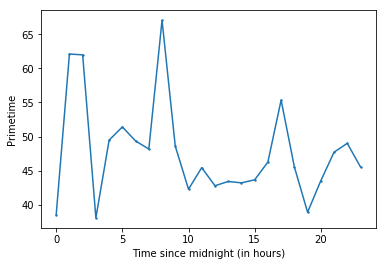

In [85]:
primetime_by_day_smooth = [{} for l in range(0,7)] #where monday is 0
primetime_aggregate_smooth = {}
number_points_per_time = [{} for l in range(0,7)]

for driver_id, onboard_date in driver_ids:
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            ride_distance = ride_ids_map[ride_id][0]
            ride_duration = ride_ids_map[ride_id][1]
            ride_prime_time = ride_ids_map[ride_id][2]
            
            if(ride_prime_time != 0):
                day = ride_timestamps_map[ride_id]['arrived_at'].weekday()
                now = ride_timestamps_map[ride_id]['requested_at']
                hrs_since_midnight = (int)((now - now.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()/60.0/60.0)

                if(hrs_since_midnight in primetime_by_day_smooth[day]):
                    primetime_by_day_smooth[day][hrs_since_midnight].append(ride_prime_time)
                    primetime_aggregate_smooth[hrs_since_midnight].append(ride_prime_time)
                    number_points_per_time[day][hrs_since_midnight] += 1
                elif(hrs_since_midnight in number_points_per_time):
                    primetime_by_day_smooth[day][hrs_since_midnight] = [ride_prime_time]
                    primetime_aggregate_smooth[hrs_since_midnight].append(ride_prime_time)
                    number_points_per_time[day][hrs_since_midnight] = 1
                else:
                    primetime_by_day_smooth[day][hrs_since_midnight] = [ride_prime_time]
                    primetime_aggregate_smooth[hrs_since_midnight] = [ride_prime_time]
                    number_points_per_time[day][hrs_since_midnight] = 1
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass

days_of_the_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for counter in range(0,7):
    print("Prime Time Demand on " + days_of_the_week[counter])
    plt.xlabel('Time since midnight (in hours)')
    plt.ylabel('Primetime')
    x = []
    y = []
    for time in number_points_per_time[counter].keys():
        x.append(time)
        y.append(sum(primetime_by_day_smooth[counter][time])/(0.0+ number_points_per_time[counter][time]))
    plt.scatter(x,y,s=2)
    plt.plot(x,y)
    plt.show()

print("Aggregate Prime Time Demand")
plt.xlabel('Time since midnight (in hours)')
plt.ylabel('Primetime')
x = []
y = []
for time in [k for k in range(0,24)]:
    x.append(time)
    y.append(sum(primetime_aggregate_smooth[time])/(sum([number_points_per_time[j][time] for j in range(0,7)])+0.0))
plt.scatter(x,y,s=2)
plt.plot(x,y)
plt.show()

Percent of a Driver's Rides that are Primetime


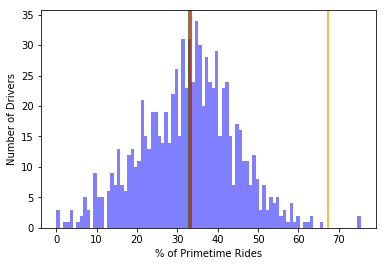

('Percent Primetime Rides Mean:', 32.77197433269769, 'Percent Primetime Rides Median:', 33.333333333333336)
('Average Percent non-Primetime Rides', 67.22802566730232)


In [130]:
percent_prime_time = []
average_percent_non_primetime = []
for driver_id, onboard_date in driver_ids:
    prime_time_number = 0
    total_rides = 0
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            if(ride_ids_map[ride_id][2] > 0):
                prime_time_number += 1
            total_rides += 1
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if(total_rides > 0):
        percent_prime_time.append(100.0*(prime_time_number+0.0)/total_rides)
        average_percent_non_primetime.append(100.0-(100.0*(prime_time_number+0.0)/total_rides))

percent_primetime_mean = np.mean(np.asarray(percent_prime_time))
percent_primetime_median = np.median(np.asarray(percent_prime_time))        
num_bins = 90
print("Percent of a Driver's Rides that are Primetime > 0")
plt.xlabel('% of Primetime Rides')
plt.ylabel('Number of Drivers')
n, bins, patches = plt.hist(percent_prime_time, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=percent_primetime_mean, color='green')
plt.axvline(x=percent_primetime_median, color='red')
plt.axvline(x=np.mean(np.asarray(average_percent_non_primetime)), color='orange')
plt.show()
print("Percent Primetime Rides Mean:", percent_primetime_mean, "Percent Primetime Rides Median:", percent_primetime_median)
print("Average Percent non-Primetime Rides", np.mean(np.asarray(average_percent_non_primetime)))

Percent of a Driver's Rides that are Primetime greater than 0
Percent less than the mean: 47.0725995316
Percent of 0% primetime rides greater than threshold: 0.351288056206


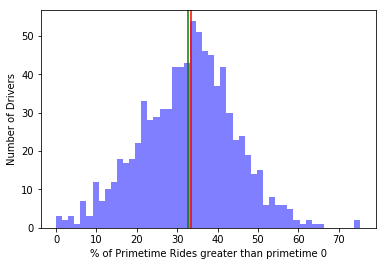

('Percent Primetime Rides Mean:', 32.77197433269769, 'Percent Primetime Rides Median:', 33.333333333333336)


Percent of a Driver's Rides that are Primetime greater than 25
Percent less than the mean: 48.9461358314
Percent of 0% primetime rides greater than threshold: 1.87353629977


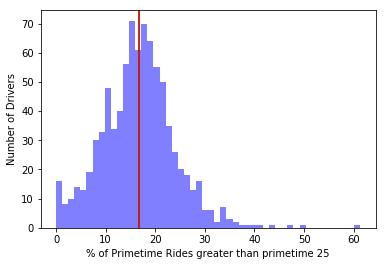

('Percent Primetime Rides Mean:', 16.655695888603525, 'Percent Primetime Rides Median:', 16.706809546900562)


Percent of a Driver's Rides that are Primetime greater than 50
Percent less than the mean: 54.3325526932
Percent of 0% primetime rides greater than threshold: 6.08899297424


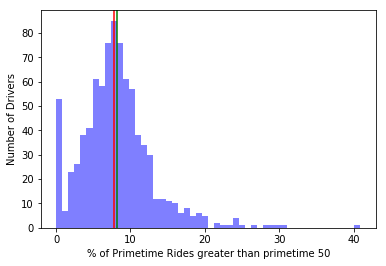

('Percent Primetime Rides Mean:', 8.136216459552186, 'Percent Primetime Rides Median:', 7.818784795290483)


Percent of a Driver's Rides that are Primetime greater than 75
Percent less than the mean: 54.9180327869
Percent of 0% primetime rides greater than threshold: 13.2318501171


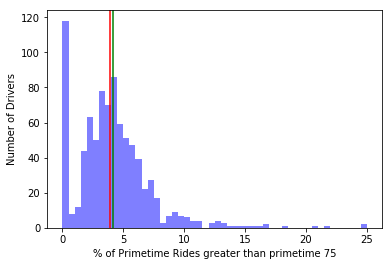

('Percent Primetime Rides Mean:', 4.143058151034996, 'Percent Primetime Rides Median:', 3.8703886438481563)


Percent of a Driver's Rides that are Primetime greater than 100
Percent less than the mean: 61.3583138173
Percent of 0% primetime rides greater than threshold: 32.5526932084


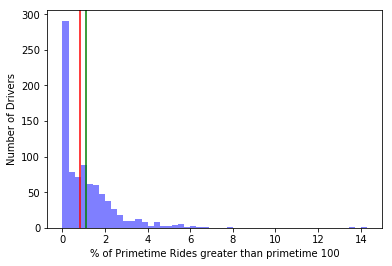

('Percent Primetime Rides Mean:', 1.1193364583573844, 'Percent Primetime Rides Median:', 0.819672131147541)


Percent of a Driver's Rides that are Primetime greater than 150
Percent less than the mean: 69.3208430913
Percent of 0% primetime rides greater than threshold: 62.9976580796


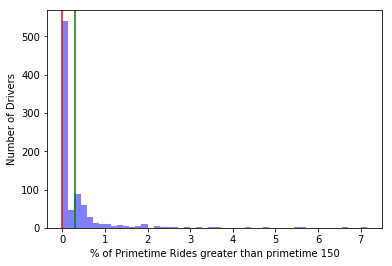

('Percent Primetime Rides Mean:', 0.294276016639451, 'Percent Primetime Rides Median:', 0.0)


Percent of a Driver's Rides that are Primetime greater than 200
Percent less than the mean: 86.1826697892
Percent of 0% primetime rides greater than threshold: 86.1826697892


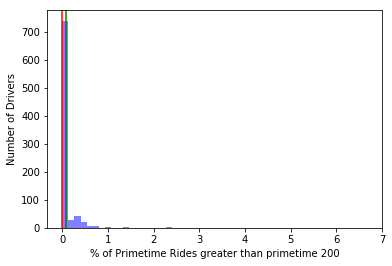

('Percent Primetime Rides Mean:', 0.08304215221416326, 'Percent Primetime Rides Median:', 0.0)


Percent of a Driver's Rides that are Primetime greater than 250
Percent less than the mean: 95.0819672131
Percent of 0% primetime rides greater than threshold: 95.0819672131


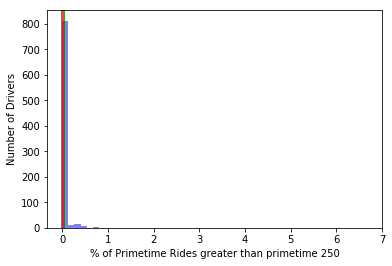

('Percent Primetime Rides Mean:', 0.032113445991336635, 'Percent Primetime Rides Median:', 0.0)


Percent of a Driver's Rides that are Primetime greater than 300
Percent less than the mean: 98.0093676815
Percent of 0% primetime rides greater than threshold: 98.0093676815


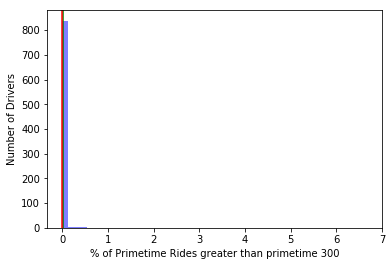

('Percent Primetime Rides Mean:', 0.018378356762163418, 'Percent Primetime Rides Median:', 0.0)


Percent of a Driver's Rides that are Primetime greater than 350
Percent less than the mean: 99.0632318501
Percent of 0% primetime rides greater than threshold: 99.0632318501


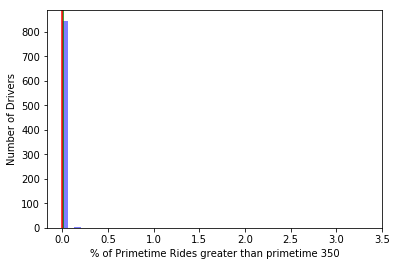

('Percent Primetime Rides Mean:', 0.010254455253758331, 'Percent Primetime Rides Median:', 0.0)


Percent of a Driver's Rides that are Primetime greater than 400
Percent less than the mean: 99.8829039813
Percent of 0% primetime rides greater than threshold: 99.8829039813


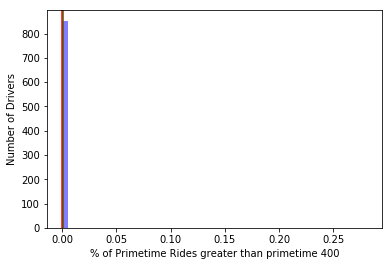

('Percent Primetime Rides Mean:', 0.0003289214009420309, 'Percent Primetime Rides Median:', 0.0)




In [153]:
thresholds = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400]
for thres in thresholds:
    percent_prime_time = []
    for driver_id, onboard_date in driver_ids:
        prime_time_number = 0
        total_rides = 0
        for ride_id in driver_to_ride.get(driver_id,[]):
            try:
                if(ride_ids_map[ride_id][2] > thres):
                    prime_time_number += 1
                total_rides += 1
            except: # Note: This happens a lot...
                #print("Missing data... ride_id:",ride_id,"does not exist.")
                pass
        if(total_rides > 0):
            percent_prime_time.append(100.0*(prime_time_number+0.0)/total_rides)
    
    percent_primetime_mean = np.mean(np.asarray(percent_prime_time))
    percent_lessthan_mean = (len([i for i in percent_prime_time if i < percent_primetime_mean])+0.0)/len(percent_prime_time)
    percent_zero = (len([i for i in percent_prime_time if i == 0])+0.0)/len(percent_prime_time)
    percent_primetime_median = np.median(np.asarray(percent_prime_time))        
    num_bins = 50
    print("Percent of a Driver's Rides that are Primetime greater than " + str(thres))
    print("Percent less than the mean: " + str(percent_lessthan_mean*100))
    print("Percent of 0% primetime rides greater than threshold: " + str(percent_zero*100))
    plt.xlabel('% of Primetime Rides greater than primetime ' + str(thres))
    plt.ylabel('Number of Drivers')
    n, bins, patches = plt.hist(percent_prime_time, num_bins, facecolor='blue', alpha=0.5)
    plt.axvline(x=percent_primetime_mean, color='green')
    plt.axvline(x=percent_primetime_median, color='red')
    plt.show()
    print("Percent Primetime Rides Mean:", percent_primetime_mean, "Percent Primetime Rides Median:", percent_primetime_median)
    print("")
    print("")

## Monetary Analysis

### Average ride value for each driver

Average Ride Monetary Value per Driver


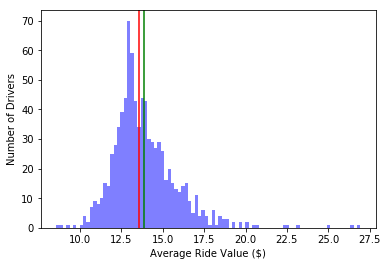

('Average Ride Value Mean:', 13.899878645423211, 'Average Ride Value Median:', 13.552039757405044)


In [129]:
average_ride_value = []
for driver_id, onboard_date in driver_ids:
    ride_value = 0
    total_rides = 0
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            ride_distance = ride_ids_map[ride_id][0]
            ride_duration = ride_ids_map[ride_id][1]
            ride_prime_time = ride_ids_map[ride_id][2]

            ride_value = ride_value + ride_cost(ride_distance,ride_duration,ride_prime_time)
            total_rides += 1
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if(total_rides > 0):
        average_ride_value.append((ride_value+0.0)/total_rides)

average_ride_value_mean = np.mean(np.asarray(average_ride_value))
average_ride_value_median = np.median(np.asarray(average_ride_value))        
num_bins = 90
print("Average Ride Monetary Value per Driver")
plt.xlabel('Average Ride Value ($)')
plt.ylabel('Number of Drivers')
n, bins, patches = plt.hist(average_ride_value, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=average_ride_value_mean, color='green')
plt.axvline(x=average_ride_value_median, color='red')
plt.show()
print("Average Ride Value Mean:", average_ride_value_mean, "Average Ride Value Median:", average_ride_value_median)

Average Ride Monetary Value per Driver on Weekend


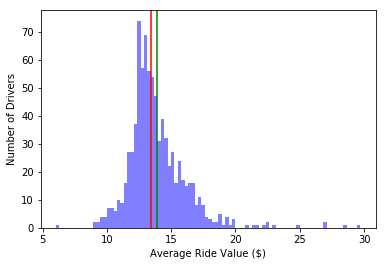

('Average Ride Value Mean:', 13.860685980108473, 'Average Ride Value Median:', 13.419012066832959)
Average Ride Monetary Value per Driver on Weekday


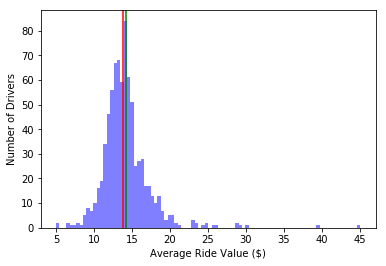

('Average Ride Value Mean:', 14.15025614622231, 'Average Ride Value Median:', 13.841539124380928)


In [132]:
average_ride_value = [[] for l in range(2)] #weekday and then weekend
for driver_id, onboard_date in driver_ids:
    ride_value = [0,0]
    total_rides = [0,0]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            ride_distance = ride_ids_map[ride_id][0]
            ride_duration = ride_ids_map[ride_id][1]
            ride_prime_time = ride_ids_map[ride_id][2]
            
            if(ride_timestamps_map[ride_id]['arrived_at'].weekday()== 5 or ride_timestamps_map[ride_id]['arrived_at'].weekday()== 6):
                ride_value[1] += ride_cost(ride_distance,ride_duration,ride_prime_time)
                total_rides[1] += 1
            else:
                ride_value[0] += ride_cost(ride_distance,ride_duration,ride_prime_time)
                total_rides[0] += 1
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if(total_rides[0] > 0):
        average_ride_value[0].append((ride_value[0]+0.0)/total_rides[0])
    if(total_rides[1] > 0):
        average_ride_value[1].append((ride_value[1]+0.0)/total_rides[1])

average_ride_value_mean = np.mean(np.asarray(average_ride_value[0]))
average_ride_value_median = np.median(np.asarray(average_ride_value[0]))        
num_bins = 90
print("Average Ride Monetary Value per Driver on Weekend")
plt.xlabel('Average Ride Value ($)')
plt.ylabel('Number of Drivers')
n, bins, patches = plt.hist(average_ride_value[0], num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=average_ride_value_mean, color='green')
plt.axvline(x=average_ride_value_median, color='red')
plt.show()
print("Average Ride Value Mean:", average_ride_value_mean, "Average Ride Value Median:", average_ride_value_median)

average_ride_value_mean = np.mean(np.asarray(average_ride_value[1]))
average_ride_value_median = np.median(np.asarray(average_ride_value[1]))
print("Average Ride Monetary Value per Driver on Weekday")
plt.xlabel('Average Ride Value ($)')
plt.ylabel('Number of Drivers')
n, bins, patches = plt.hist(average_ride_value[1], num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=average_ride_value_mean, color='green')
plt.axvline(x=average_ride_value_median, color='red')
plt.show()
print("Average Ride Value Mean:", average_ride_value_mean, "Average Ride Value Median:", average_ride_value_median)